# PDK

gdsfactory includes a generic PDK, that you can use as an inspiration to create your own pdks.

The PDK allows you to register:

- `cell` functions that return Components from a ComponentSpec (string, Component, ComponentFactory or dict). Also known as PCells (parametric cells).
- `cross_section` functions that return CrossSection from a CrossSection Spec (string, CrossSection, CrossSectionFactory or dict).
- `layers` that return a GDS Layer from a string, an int or a Tuple[int, int].


You can only have one active PDK at a time.
Thanks to PDK you can access components, cross_sections or layers using a string.

Depending on the active pdk:

- `get_layer` returns a Layer from the registered layers.
- `get_component` returns a Component from the registered cells or containers.
- `get_cross_section` returns a CrossSection from the registered cross_sections.

## layers

GDS layers are a tuple of two integer number `gdslayer/gdspurpose`

You can define all the layers from your PDK:

1. From a Klayout `lyp` (layer properties file).
2. From scratch, adding all your layers into a class.


Lets generate the layers definition code from a KLayout `lyp` file.

In [1]:
import pathlib
from typing import Callable, Tuple

import pytest
from pydantic import BaseModel
from pytest_regressions.data_regression import DataRegressionFixture

import gdsfactory as gf
from gdsfactory.add_pins import add_pin_rectangle_inside
from gdsfactory.component import Component
from gdsfactory.config import PATH
from gdsfactory.cross_section import cross_section
from gdsfactory.decorators import flatten_invalid_refs, has_valid_transformations
from gdsfactory.difftest import difftest
from gdsfactory.generic_tech import get_generic_pdk
from gdsfactory.technology import (
    LayerLevel,
    LayerStack,
    LayerView,
    LayerViews,
    lyp_to_dataclass,
)
from gdsfactory.types import Layer, LayerSpec

print(lyp_to_dataclass(PATH.klayout_lyp))

2023-01-22 16:11:58.455 | INFO     | gdsfactory.config:<module>:50 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 6.23.4


2023-01-22 16:11:59.280 | INFO     | gdsfactory.technology.layer_views:__init__:779 - Importing LayerViews from KLayout layer properties file: /home/runner/work/gdsfactory/gdsfactory/gdsfactory/generic_tech/klayout/tech/layers.lyp.



from pydantic import BaseModel
from gdsfactory.types import Layer


class LayerMap(BaseModel):
    CAPACITOR: Layer = (42, 0)
    DEEPETCH: Layer = (3, 6)
    DEEPTRENCH: Layer = (4, 0)
    DICING: Layer = (65, 0)
    DRC_EXCLUDE: Layer = (67, 0)
    DRC_MARKER: Layer = (205, 0)
    DevRec: Layer = (68, 0)
    ERROR_MARKER: Layer = (207, 0)
    Errors: Layer = (69, 0)
    FLOORPLAN: Layer = (64, 0)
    FbrTgt: Layer = (81, 0)
    GE: Layer = (5, 0)
    GENPP: Layer = (26, 0)
    GEPPP: Layer = (29, 0)
    LABEL_INSTANCES: Layer = (206, 0)
    LABEL_OPTICAL_IO: Layer = (201, 0)
    LABEL_SETTINGS: Layer = (202, 0)
    Lumerical: Layer = (733, 0)
    M1: Layer = (41, 0)
    M1TILES: Layer = (191, 0)
    M2: Layer = (45, 0)
    M3: Layer = (49, 0)
    METALOPEN: Layer = (46, 0)
    MH: Layer = (47, 0)
    MONITOR: Layer = (101, 0)
    N: Layer = (20, 0)
    NOTILE_M1: Layer = (71, 0)
    NOTILE_M2: Layer = (72, 0)
    NOTILE_M3: Layer = (73, 0)
    NP: Layer = (22, 0)
    NPP: Layer = (2

In [2]:
class LayerMap(BaseModel):
    WG: Layer = (1, 0)
    DEVREC: Layer = (68, 0)
    PORT: Layer = (1, 10)
    PORTE: Layer = (1, 11)
    LABEL: Layer = (201, 0)
    LABEL_INSTANCES: Layer = (206, 0)
    LABEL_SETTINGS: Layer = (202, 0)
    LUMERICAL: Layer = (733, 0)
    M1: Layer = (41, 0)
    M2: Layer = (45, 0)
    M3: Layer = (49, 0)
    N: Layer = (20, 0)
    NP: Layer = (22, 0)
    NPP: Layer = (24, 0)
    OXIDE_ETCH: Layer = (6, 0)
    P: Layer = (21, 0)
    PDPP: Layer = (27, 0)
    PP: Layer = (23, 0)
    PPP: Layer = (25, 0)
    PinRec: Layer = (1, 10)
    PinRecM: Layer = (1, 11)
    SHALLOWETCH: Layer = (2, 6)
    SILICIDE: Layer = (39, 0)
    SIM_REGION: Layer = (100, 0)
    SITILES: Layer = (190, 0)
    SLAB150: Layer = (2, 0)
    SLAB150CLAD: Layer = (2, 9)
    SLAB90: Layer = (3, 0)
    SLAB90CLAD: Layer = (3, 1)
    SOURCE: Layer = (110, 0)
    TE: Layer = (203, 0)
    TEXT: Layer = (66, 0)
    TM: Layer = (204, 0)
    Text: Layer = (66, 0)
    VIA1: Layer = (44, 0)
    VIA2: Layer = (43, 0)
    VIAC: Layer = (40, 0)
    WGCLAD: Layer = (111, 0)
    WGN: Layer = (34, 0)
    WGNCLAD: Layer = (36, 0)

    class Config:
        frozen = True
        extra = "forbid"


LAYER = LayerMap()

There are some default layers in some generic components and cross_sections, that it may be convenient adding.

| Layer          | Purpose                                                      |
| -------------- | ------------------------------------------------------------ |
| DEVREC         | device recognition layer. For connectivity checks.           |
| PORT           | optical port pins. For connectivity checks.                  |
| PORTE          | electrical port pins. For connectivity checks.               |
| SHOW_PORTS     | add port pin markers when `Component.show(show_ports=True)`  |
| LABEL          | for adding labels to grating couplers for automatic testing. |
| LABEL_INSTANCE | for adding instance labels on `gf.read.from_yaml`            |
| TE             | for TE polarization fiber marker.                            |
| TM             | for TM polarization fiber marker.                            |


```python
class LayersConvenient(BaseModel):
    DEVREC: Layer = (68, 0)
    PORT: Layer = (1, 10)  # PinRec optical
    PORTE: Layer = (1, 11)  # PinRec electrical
    SHOW_PORTS: Layer = (1, 12)

    LABEL: Layer = (201, 0)
    LABEL_INSTANCE: Layer = (66, 0)
    TE: Layer = (203, 0)
    TM: Layer = (204, 0)

```

## cross_sections

You can create a `CrossSection` from scratch or you can customize the cross_section functions in `gf.cross_section`

In [3]:
strip2 = gf.partial(gf.cross_section.strip, layer=(2, 0))

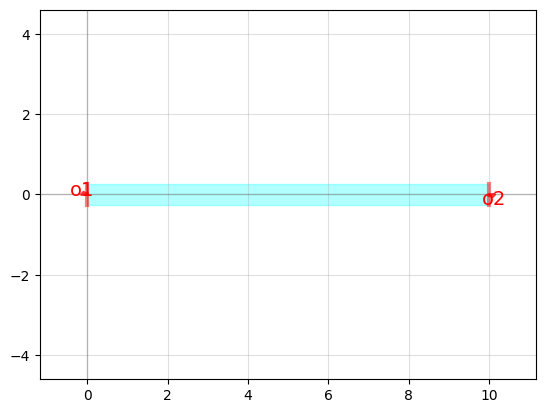

straight_376c0643: uid b7d26f3b, ports ['o1', 'o2'], references [], 1 polygons

In [4]:
c = gf.components.straight(cross_section=strip2)
c

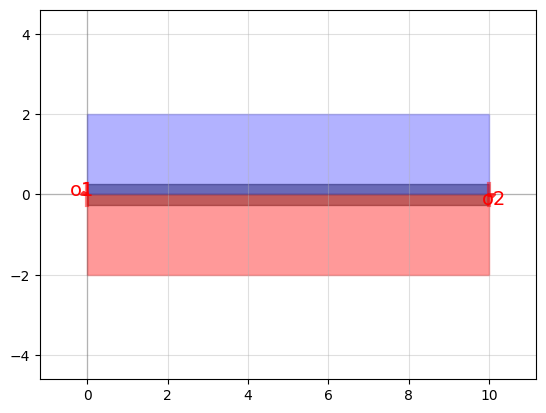

straight_0ff5cea5: uid 2f303d61, ports ['o1', 'o2'], references [], 3 polygons

In [5]:
pin = gf.partial(
    gf.cross_section.strip,
    sections=(
        gf.Section(width=2, layer=gf.LAYER.N, offset=+1),
        gf.Section(width=2, layer=gf.LAYER.P, offset=-1),
    ),
)
c = gf.components.straight(cross_section=pin)
c

In [6]:
strip_wide = gf.partial(gf.cross_section.strip, width=3)

In [7]:
strip = gf.partial(
    gf.cross_section.strip, auto_widen=True
)  # auto_widen tapers to wider waveguides for lower loss in long straight sections.

In [8]:
cross_sections = dict(strip_wide=strip_wide, pin=pin, strip=strip)

## cells

Cells are functions that return Components. They are parametrized and accept also cells as parameters, so you can build many levels of complexity. Cells are also known as PCells or parametric cells.

You can customize the function default arguments easily thanks to `functools.partial`
Lets customize the default arguments of a library of cells.

For example, you can make some wide MMIs for a particular technology. Lets say the best MMI width you found it to be 9um.

In [9]:
mmi1x2 = gf.partial(gf.components.mmi1x2, width_mmi=9)
mmi2x2 = gf.partial(gf.components.mmi2x2, width_mmi=9)

cells = dict(mmi1x2=mmi1x2, mmi2x2=mmi2x2)

## PDK

You can register Layers, ComponentFactories (Parametric cells) and CrossSectionFactories (cross_sections) into a PDK. Then you can access them by a string after you activate the pdk `PDK.activate()`.

### LayerSpec

You can access layers from the active Pdk using the layer name or a tuple/list of two numbers.

In [10]:
pdk1 = gf.Pdk(
    name="fab1",
    layers=LAYER.dict(),
    cross_sections=cross_sections,
    cells=cells,
    base_pdk=gf.generic_tech.get_generic_pdk(),
    sparameters_path=gf.config.sparameters_path,
    layer_views=gf.generic_tech.LAYER_VIEWS,
)
pdk1.activate()

2023-01-22 16:12:00.156 | INFO     | gdsfactory.pdk:activate:124 - 'fab1' PDK is now active


In [11]:
pdk1.get_layer("WG")

(1, 0)

In [12]:
pdk1.get_layer([1, 0])

[1, 0]

### CrossSectionSpec

You can access cross_sections from the pdk from the cross_section name, or using a dict to customize the CrossSection

In [13]:
pdk1.get_cross_section("pin")

CrossSection(layer='WG', width=0.5, offset=0.0, radius=10.0, width_wide=None, auto_widen=False, auto_widen_minimum_length=200.0, taper_length=10.0, bbox_layers=[], bbox_offsets=[], cladding_layers=None, cladding_offsets=None, sections=[Section(width=2.0, offset=1.0, layer=(20, 0), port_names=(None, None), port_types=('optical', 'optical'), name=None, hidden=False), Section(width=2.0, offset=-1.0, layer=(21, 0), port_names=(None, None), port_types=('optical', 'optical'), name=None, hidden=False)], port_names=('o1', 'o2'), port_types=('optical', 'optical'), min_length=0.01, start_straight_length=0.01, end_straight_length=0.01, snap_to_grid=None, decorator=None, add_pins=None, add_bbox=None, info={}, name=None, add_center_section=True, mirror=False)

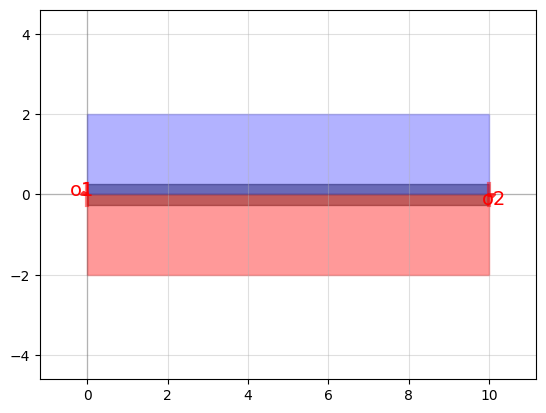

straight_cross_sectionpin: uid 5996a86b, ports ['o1', 'o2'], references [], 3 polygons

In [14]:
cross_section_spec_string = "pin"
gf.components.straight(cross_section=cross_section_spec_string)

layer='WG' width=2.0 offset=0.0 radius=10.0 width_wide=None auto_widen=False auto_widen_minimum_length=200.0 taper_length=10.0 bbox_layers=[] bbox_offsets=[] cladding_layers=None cladding_offsets=None sections=[Section(width=2.0, offset=1.0, layer=(20, 0), port_names=(None, None), port_types=('optical', 'optical'), name=None, hidden=False), Section(width=2.0, offset=-1.0, layer=(21, 0), port_names=(None, None), port_types=('optical', 'optical'), name=None, hidden=False)] port_names=('o1', 'o2') port_types=('optical', 'optical') min_length=0.01 start_straight_length=0.01 end_straight_length=0.01 snap_to_grid=None decorator=None add_pins=None add_bbox=None info={} name=None add_center_section=True mirror=False


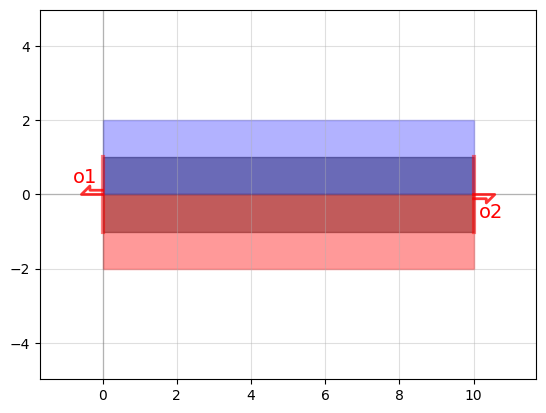

straight_361ab848: uid 440cd001, ports ['o1', 'o2'], references [], 3 polygons

In [15]:
cross_section_spec_dict = dict(cross_section="pin", settings=dict(width=2))
print(pdk1.get_cross_section(cross_section_spec_dict))
wg_pin = gf.components.straight(cross_section=cross_section_spec_dict)
wg_pin

### ComponentSpec

You can get Component from the active pdk using the cell name (string) or a dict.

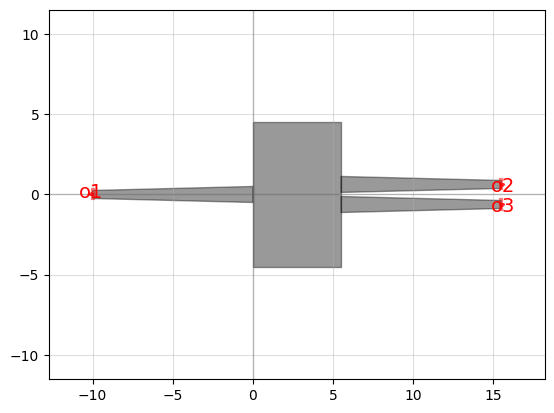

mmi1x2_width_mmi9: uid 2e3da9fb, ports ['o1', 'o2', 'o3'], references [], 4 polygons

In [16]:
pdk1.get_component("mmi1x2")

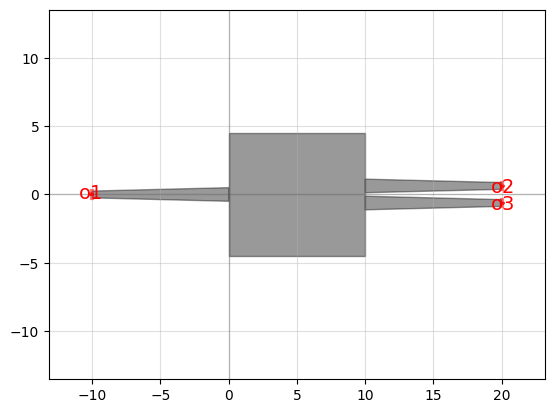

mmi1x2_length_mmi10_width_mmi9: uid e3bcb134, ports ['o1', 'o2', 'o3'], references [], 4 polygons

In [17]:
pdk1.get_component(dict(component="mmi1x2", settings=dict(length_mmi=10)))

Now you can define PDKs for different Fabs

### FabA

FabA only has one waveguide layer available that is defined in GDS layer (30, 0)

The waveguide traces are 2um wide.

2023-01-22 16:12:00.906 | INFO     | gdsfactory.pdk:activate:124 - 'Fab_A' PDK is now active


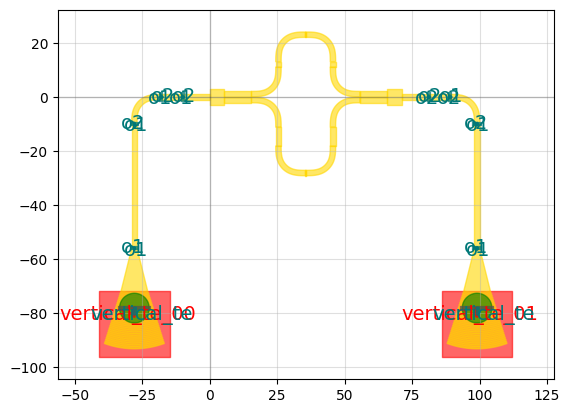

mzi_add_fiber_array_dccdf3e0: uid 335eb6ff, ports ['vertical_te_00', 'vertical_te_01'], references ['bend_euler_1', 'straight_1', 'straight_2', 'bend_euler_2', 'straight_3', 'straight_4', 'grating_coupler_elliptical_1', 'grating_coupler_elliptical_2', 'mzi_1'], 0 polygons

In [18]:
nm = 1e-3


class LayerMap(BaseModel):
    WG: Layer = (34, 0)
    SLAB150: Layer = (2, 0)
    DEVREC: Layer = (68, 0)
    PORT: Layer = (1, 10)
    PORTE: Layer = (1, 11)
    TE: Layer = (203, 0)
    TM: Layer = (204, 0)
    TEXT: Layer = (66, 0)


LAYER = LayerMap()


class FabALayerViews(LayerViews):
    WG = LayerView(color="gold")
    SLAB150 = LayerView(color="red")
    TE = LayerView(color="green")


LAYER_VIEWS = FabALayerViews(layer_map=LAYER.dict())


def get_layer_stack_faba(
    thickness_wg: float = 500 * nm, thickness_slab: float = 150 * nm
) -> LayerStack:
    """Returns fabA LayerStack"""

    class FabALayerStack(LayerStack):
        strip = LayerLevel(
            layer=LAYER.WG,
            thickness=thickness_wg,
            zmin=0.0,
            material="si",
        )
        strip2 = LayerLevel(
            layer=LAYER.SLAB150,
            thickness=thickness_slab,
            zmin=0.0,
            material="si",
        )

    return FabALayerStack()


LAYER_STACK = get_layer_stack_faba()

WIDTH = 2

# Specify a cross_section to use
strip = gf.partial(gf.cross_section.cross_section, width=WIDTH, layer=LAYER.WG)

mmi1x2 = gf.partial(
    gf.components.mmi1x2,
    width=WIDTH,
    width_taper=WIDTH,
    width_mmi=3 * WIDTH,
    cross_section=strip,
)

generic_pdk = gf.generic_tech.get_generic_pdk()

fab_a = gf.Pdk(
    name="Fab_A",
    cells=dict(mmi1x2=mmi1x2),
    cross_sections=dict(strip=strip),
    layers=LAYER.dict(),
    base_pdk=generic_pdk,
    sparameters_path=gf.config.sparameters_path,
    layer_views=LAYER_VIEWS,
    layer_stack=LAYER_STACK,
)
fab_a.activate()

gc = gf.partial(
    gf.components.grating_coupler_elliptical_te, layer=LAYER.WG, cross_section=strip
)

c = gf.components.mzi()
c_gc = gf.routing.add_fiber_array(component=c, grating_coupler=gc, with_loopback=False)
c_gc

In [19]:
c = c_gc.to_3d()
c.show(show_ports=True)

### FabB

FabB has photonic waveguides that require rectangular cladding layers to avoid dopants

Lets say that the waveguides are defined in layer (2, 0) and are 0.3um wide, 1um thick


2023-01-22 16:12:02.103 | INFO     | gdsfactory.pdk:activate:124 - 'fab_b' PDK is now active


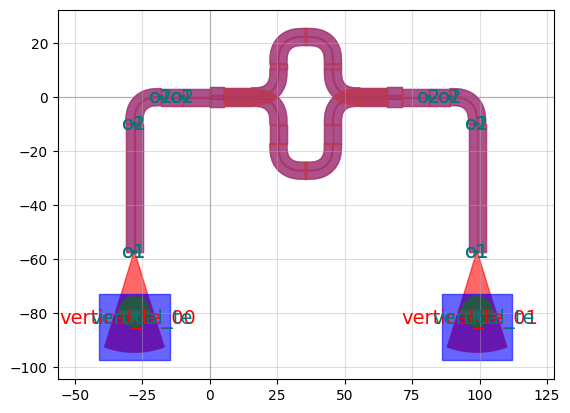

mzi_a1b57e95_add_fiber__5c2b506d: uid bf45910b, ports ['vertical_te_00', 'vertical_te_01'], references ['bend_euler_1', 'straight_1', 'straight_2', 'bend_euler_2', 'straight_3', 'straight_4', 'grating_coupler_elliptical_1', 'grating_coupler_elliptical_2', 'mzi_1'], 0 polygons

In [20]:
nm = 1e-3


class LayerMap(BaseModel):
    WG: Layer = (2, 0)
    SLAB150: Layer = (3, 0)
    DEVREC: Layer = (68, 0)
    PORT: Layer = (1, 10)
    PORTE: Layer = (1, 11)
    TE: Layer = (203, 0)
    TM: Layer = (204, 0)
    TEXT: Layer = (66, 0)
    LABEL: Layer = (201, 0)
    DOPING_BLOCK1: Layer = (61, 0)
    DOPING_BLOCK2: Layer = (62, 0)


LAYER = LayerMap()

# The LayerViews class supports grouping LayerViews within each other. These groups are maintained when exporting a LayerViews object to a KLayout layer properties (.lyp) file.
class FabBLayerViews(LayerViews):
    WG = LayerView(color="red")
    SLAB150 = LayerView(color="blue")
    TE = LayerView(color="green")
    PORT = LayerView(color="green", alpha=0)

    class DopingBlockGroup(LayerView):
        DOPING_BLOCK1 = LayerView(color="green", alpha=0)
        DOPING_BLOCK2 = LayerView(color="green", alpha=0)

    DopingBlocks = DopingBlockGroup()


LAYER_VIEWS = FabBLayerViews(layer_map=LAYER)


def get_layer_stack_fab_b(
    thickness_wg: float = 1000 * nm, thickness_slab: float = 150 * nm
) -> LayerStack:
    """Returns fabA LayerStack."""

    class FabBLayerStack(LayerStack):
        strip = LayerLevel(
            layer=LAYER.WG,
            thickness=thickness_wg,
            zmin=0.0,
            material="si",
        )
        strip2 = LayerLevel(
            layer=LAYER.SLAB150,
            thickness=thickness_slab,
            zmin=0.0,
            material="si",
        )

    return FabBLayerStack()


LAYER_STACK = get_layer_stack_fab_b()


WIDTH = 0.3
BBOX_LAYERS = (LAYER.DOPING_BLOCK1, LAYER.DOPING_BLOCK2)
BBOX_OFFSETS = (3, 3)

# use cladding_layers and cladding_offsets if the foundry prefers conformal blocking doping layers instead of squared
# bbox_layers and bbox_offsets makes rectangular waveguides.
strip = gf.partial(
    gf.cross_section.cross_section,
    width=WIDTH,
    layer=LAYER.WG,
    # bbox_layers=BBOX_LAYERS,
    # bbox_offsets=BBOX_OFFSETS,
    cladding_layers=BBOX_LAYERS,
    cladding_offsets=BBOX_OFFSETS,
)

straight = gf.partial(gf.components.straight, cross_section=strip)
bend_euler = gf.partial(gf.components.bend_euler, cross_section=strip)
mmi1x2 = gf.partial(
    gf.components.mmi1x2,
    cross_section=strip,
    width=WIDTH,
    width_taper=WIDTH,
    width_mmi=4 * WIDTH,
)
mzi = gf.partial(gf.components.mzi, cross_section=strip, splitter=mmi1x2)
gc = gf.partial(
    gf.components.grating_coupler_elliptical_te, layer=LAYER.WG, cross_section=strip
)

cells = dict(
    gc=gc,
    mzi=mzi,
    mmi1x2=mmi1x2,
    bend_euler=bend_euler,
    straight=straight,
    taper=gf.components.taper,
)
cross_sections = dict(strip=strip)

pdk = gf.Pdk(
    name="fab_b",
    cells=cells,
    cross_sections=cross_sections,
    layers=LAYER.dict(),
    sparameters_path=gf.config.sparameters_path,
    layer_views=LAYER_VIEWS,
    layer_stack=LAYER_STACK,
)
pdk.activate()


c = mzi()
wg_gc = gf.routing.add_fiber_array(
    component=c, grating_coupler=gc, cross_section=strip, with_loopback=False
)
wg_gc

In [21]:
c = wg_gc.to_3d()
c.show(show_ports=True)

### FabC

Lets assume that fab C has similar technology to the generic PDK in gdsfactory and that you just want to remap some layers, and adjust the widths.


In [22]:
nm = 1e-3


class LayerMap(BaseModel):
    WG: Layer = (10, 1)
    WG_CLAD: Layer = (10, 2)
    WGN: Layer = (34, 0)
    WGN_CLAD: Layer = (36, 0)
    SLAB150: Layer = (2, 0)
    DEVREC: Layer = (68, 0)
    PORT: Layer = (1, 10)
    PORTE: Layer = (1, 11)
    TE: Layer = (203, 0)
    TM: Layer = (204, 0)
    TEXT: Layer = (66, 0)
    LABEL: Layer = (201, 0)


LAYER = LayerMap()
WIDTH_NITRIDE_OBAND = 0.9
WIDTH_NITRIDE_CBAND = 1.0
PORT_TYPE_TO_LAYER = dict(optical=(100, 0))

# This is something you usually define in KLayout
class FabCLayerViews(LayerViews):
    WG = LayerView(color="black")
    SLAB150 = LayerView(color="blue")
    WGN = LayerView(color="orange")
    WGN_CLAD = LayerView(color="blue", alpha=0, visible=False)

    class SimulationGroup(LayerView):
        TE = LayerView(color="green")
        PORT = LayerView(color="green", alpha=0)

    Simulation = SimulationGroup()

    class DopingGroup(LayerView):
        DOPING_BLOCK1 = LayerView(color="green", alpha=0, visible=False)
        DOPING_BLOCK2 = LayerView(color="green", alpha=0, visible=False)

    Doping = DopingGroup()


LAYER_VIEWS = FabCLayerViews(layer_map=LAYER)


def get_layer_stack_fab_c(
    thickness_wg: float = 350.0 * nm, thickness_clad: float = 3.0
) -> LayerStack:
    """Returns generic LayerStack"""

    class FabCLayerStack(LayerStack):
        core = LayerLevel(
            layer=LAYER.WGN,
            thickness=thickness_wg,
            zmin=0,
        )
        clad = LayerLevel(
            layer=LAYER.WGN_CLAD,
            thickness=thickness_clad,
            zmin=0,
        )

    return FabCLayerStack()


LAYER_STACK = get_layer_stack_fab_c()


def add_pins(
    component: Component,
    function: Callable = add_pin_rectangle_inside,
    pin_length: float = 0.5,
    port_layer: Layer = LAYER.PORT,
    **kwargs,
) -> Component:
    """Add Pin port markers.

    Args:
        component: to add ports.
        function: to add pins.
        pin_length: in um.
        port_layer: spec.
        kwargs: function kwargs.
    """
    for p in component.ports.values():
        function(
            component=component,
            port=p,
            layer=port_layer,
            layer_label=port_layer,
            pin_length=pin_length,
            **kwargs,
        )
    return component


# cross_section constants
bbox_layers = [LAYER.WGN_CLAD]
bbox_offsets = [3]

# Nitride Cband
xs_nc = gf.partial(
    cross_section,
    width=WIDTH_NITRIDE_CBAND,
    layer=LAYER.WGN,
    bbox_layers=bbox_layers,
    bbox_offsets=bbox_offsets,
    add_pins=add_pins,
)
# Nitride Oband
xs_no = gf.partial(
    cross_section,
    width=WIDTH_NITRIDE_OBAND,
    layer=LAYER.WGN,
    bbox_layers=bbox_layers,
    bbox_offsets=bbox_offsets,
    add_pins=add_pins,
)


cross_sections = dict(xs_nc=xs_nc, xs_no=xs_no, strip=xs_nc)

# LEAF cells have pins
mmi1x2_nc = gf.partial(
    gf.components.mmi1x2,
    width=WIDTH_NITRIDE_CBAND,
    cross_section=xs_nc,
)
mmi1x2_no = gf.partial(
    gf.components.mmi1x2,
    width=WIDTH_NITRIDE_OBAND,
    cross_section=xs_no,
)
bend_euler_nc = gf.partial(
    gf.components.bend_euler,
    cross_section=xs_nc,
)
straight_nc = gf.partial(
    gf.components.straight,
    cross_section=xs_nc,
)
bend_euler_no = gf.partial(
    gf.components.bend_euler,
    cross_section=xs_no,
)
straight_no = gf.partial(
    gf.components.straight,
    cross_section=xs_no,
)

gc_nc = gf.partial(
    gf.components.grating_coupler_elliptical_te,
    grating_line_width=0.6,
    layer=LAYER.WGN,
    cross_section=xs_nc,
)

# HIERARCHICAL cells are made of leaf cells
mzi_nc = gf.partial(
    gf.components.mzi,
    cross_section=xs_nc,
    splitter=mmi1x2_nc,
    straight=straight_nc,
    bend=bend_euler_nc,
)
mzi_no = gf.partial(
    gf.components.mzi,
    cross_section=xs_no,
    splitter=mmi1x2_no,
    straight=straight_no,
    bend=bend_euler_no,
)


cells = dict(
    mmi1x2_nc=mmi1x2_nc,
    mmi1x2_no=mmi1x2_no,
    bend_euler_nc=bend_euler_nc,
    bend_euler_no=bend_euler_no,
    straight_nc=straight_nc,
    straight_no=straight_no,
    gc_nc=gc_nc,
    mzi_nc=mzi_nc,
    mzi_no=mzi_no,
)

pdk = gf.Pdk(
    name="fab_c",
    cells=cells,
    cross_sections=cross_sections,
    layers=LAYER.dict(),
    sparameters_path=gf.config.sparameters_path,
    layer_views=LAYER_VIEWS,
    layer_stack=LAYER_STACK,
)
pdk.activate()

2023-01-22 16:12:02.761 | INFO     | gdsfactory.pdk:activate:124 - 'fab_c' PDK is now active


In [23]:
LAYER_VIEWS.layer_map.values()

dict_values([(10, 1), (10, 2), (34, 0), (36, 0), (2, 0), (68, 0), (1, 10), (1, 11), (203, 0), (204, 0), (66, 0), (201, 0)])

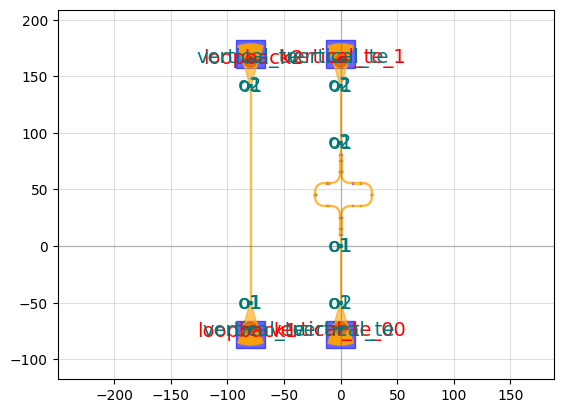

mzi_6feba2af_move_7a4df_b12248ab: uid 5cea8a8f, ports ['vertical_te_00', 'vertical_te_1', 'loopback1', 'loopback2'], references ['move_1', 'straight_1', 'straight_2', 'grating_coupler_elliptical_1', 'grating_coupler_elliptical_2', 'straight_3', 'grating_coupler_elliptical_3', 'grating_coupler_elliptical_4'], 0 polygons

In [24]:
mzi = mzi_nc()
mzi_gc = gf.routing.add_fiber_single(
    component=mzi,
    grating_coupler=gc_nc,
    cross_section=xs_nc,
    optical_routing_type=1,
    straight=straight_nc,
    bend=bend_euler_nc,
)
mzi_gc

In [25]:
c = mzi_gc.to_3d()
c.show(show_ports=True)

In [26]:
ls = get_layer_stack_fab_c()

## PDK Testing

To make sure all your PDK PCells produce the components that you want, it's important to test your PDK cells.

As you write your own cell functions you want to make sure you do not break or produced unwanted regressions later on. You should write tests for this.

Make sure you create a `test_components.py` file for pytest to test your PDK.


In [27]:
"""This code tests all your cells in the PDK

it will test 3 things:

1. difftest: will test the GDS geometry of a new GDS compared to a reference. Thanks to Klayout fast booleans.add()
2. settings test: will compare the settings in YAML with a reference YAML file.add()
3. ensure ports are on grid, to avoid port snapping errors that can create 1nm gaps later on when you build circuits.

"""

try:
    dirpath = pathlib.Path(__file__).absolute().with_suffix(".gds")
except Exception:
    dirpath = pathlib.Path.cwd()


component_names = list(pdk.cells.keys())
factory = pdk.cells


@pytest.fixture(params=component_names, scope="function")
def component_name(request) -> str:
    return request.param


def test_gds(component_name: str) -> None:
    """Avoid regressions in GDS names, shapes and layers.
    Runs XOR and computes the area."""
    component = factory[component_name]()
    test_name = f"fabc_{component_name}"
    difftest(component, test_name=test_name, dirpath=dirpath)


def test_settings(component_name: str, data_regression: DataRegressionFixture) -> None:
    """Avoid regressions in component settings and ports."""
    component = factory[component_name]()
    data_regression.check(component.to_dict())


def test_assert_ports_on_grid(component_name: str):
    """Ensures all ports are on grid to avoid 1nm gaps"""
    component = factory[component_name]()
    component.assert_ports_on_grid()

## PDK decorator

You can also define a PDK decorator (function) that runs over every PDK PCell.

2023-01-22 16:12:03.529 | INFO     | gdsfactory.pdk:activate:124 - 'generic' PDK is now active


False


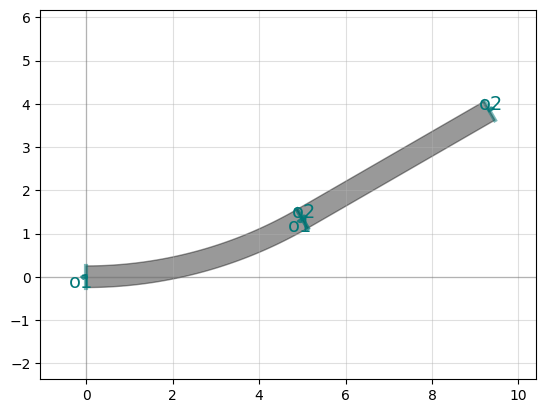

_demo_non_manhattan: uid e79f2f27, ports [], references ['bend_circular_1', 'straight_1'], 0 polygons

In [28]:
GENERIC = get_generic_pdk()
GENERIC.activate()


@gf.cell
def _demo_non_manhattan():
    c = gf.Component("bend")
    b = c << gf.components.bend_circular(angle=30)
    s = c << gf.components.straight(length=5)
    s.connect("o1", b.ports["o2"])
    return c


c1 = _demo_non_manhattan()
print(has_valid_transformations(c1))
c1

if you zoom in between the bends you will see a notch between waveguides due to non-manhattan connection between the bends.

![gap](https://i.imgur.com/jBEwy9T.png)

You an fix it with the `flatten_invalid_refs` decorator.

True


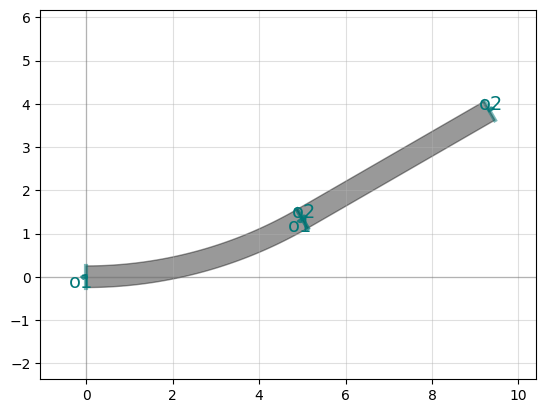

_demo_non_manhattan_60a273d3: uid 719fd199, ports [], references ['bend_circular_1', 'straight_1'], 0 polygons

In [29]:
c2 = _demo_non_manhattan(decorator=flatten_invalid_refs)
print(has_valid_transformations(c2))
c2

If you zoom in the connection the decorator you can see it fixed the issue.

![no gap](https://i.imgur.com/VbSgIjP.png)

## Version control components

For version control your component library you can use GIT

For tracking changes you can add `Component` changelog in the PCell docstring.

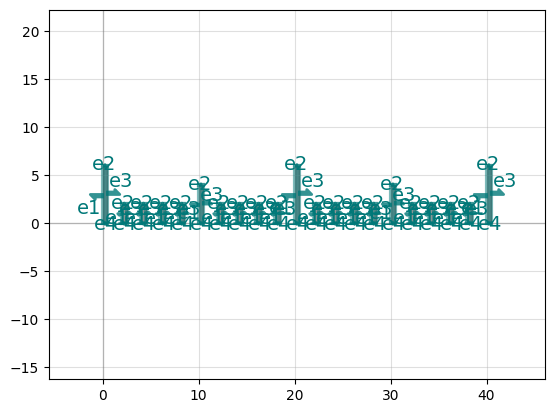

litho_ruler: uid 59a62837, ports [], references ['rectangle_1', 'rectangle_2', 'rectangle_3', 'rectangle_4', 'rectangle_5', 'rectangle_6', 'rectangle_7', 'rectangle_8', 'rectangle_9', 'rectangle_10', 'rectangle_11', 'rectangle_12', 'rectangle_13', 'rectangle_14', 'rectangle_15', 'rectangle_16', 'rectangle_17', 'rectangle_18', 'rectangle_19', 'rectangle_20', 'rectangle_21'], 0 polygons

In [30]:
@gf.cell
def litho_ruler(
    height: float = 2,
    width: float = 0.5,
    spacing: float = 2.0,
    scale: Tuple[float, ...] = (3, 1, 1, 1, 1, 2, 1, 1, 1, 1),
    num_marks: int = 21,
    layer: LayerSpec = "WG",
) -> gf.Component:
    """Ruler structure for lithographic measurement.

    Includes marks of varying scales to allow for easy reading by eye.

    Args:
        height: Height of the ruling marks in um.
        width: Width of the ruling marks in um.
        spacing: Center-to-center spacing of the ruling marks in um.
        scale: Height scale pattern of marks.
        num_marks: Total number of marks to generate.
        layer: Specific layer to put the ruler geometry on.
    """
    D = gf.Component()
    for n in range(num_marks):
        h = height * scale[n % len(scale)]
        D << gf.components.rectangle(size=(width, h), layer=layer)

    D.distribute(direction="x", spacing=spacing, separation=False, edge="x")
    D.align(alignment="ymin")
    D.flatten()
    return D


c = litho_ruler()
c

Lets assume that later on you change the code inside the PCell and want to keep a changelog.
You can use the docstring Notes to document any significant changes in the component.

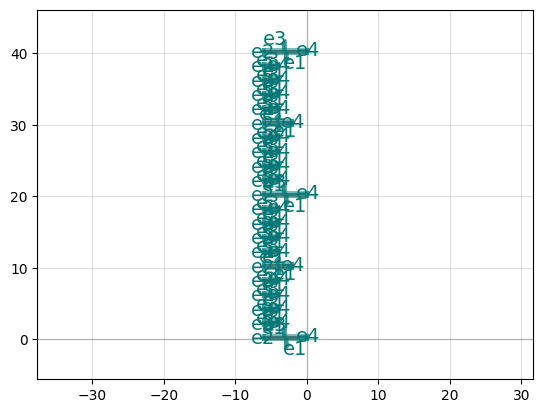

litho_ruler: uid 651bcd5e, ports [], references ['rectangle_1', 'rectangle_2', 'rectangle_3', 'rectangle_4', 'rectangle_5', 'rectangle_6', 'rectangle_7', 'rectangle_8', 'rectangle_9', 'rectangle_10', 'rectangle_11', 'rectangle_12', 'rectangle_13', 'rectangle_14', 'rectangle_15', 'rectangle_16', 'rectangle_17', 'rectangle_18', 'rectangle_19', 'rectangle_20', 'rectangle_21'], 0 polygons

In [31]:
@gf.cell
def litho_ruler(
    height: float = 2,
    width: float = 0.5,
    spacing: float = 2.0,
    scale: Tuple[float, ...] = (3, 1, 1, 1, 1, 2, 1, 1, 1, 1),
    num_marks: int = 21,
    layer: LayerSpec = "WG",
) -> gf.Component:
    """Ruler structure for lithographic measurement.

    Args:
        height: Height of the ruling marks in um.
        width: Width of the ruling marks in um.
        spacing: Center-to-center spacing of the ruling marks in um.
        scale: Height scale pattern of marks.
        num_marks: Total number of marks to generate.
        layer: Specific layer to put the ruler geometry on.

    Notes:
        5.6.7: distribute across y instead of x.
    """
    D = gf.Component()
    for n in range(num_marks):
        h = height * scale[n % len(scale)]
        ref = D << gf.components.rectangle(size=(width, h), layer=layer)
        ref.rotate(90)

    D.distribute(direction="y", spacing=spacing, separation=False, edge="y")
    D.align(alignment="xmin")
    D.flatten()
    return D


c = litho_ruler(cache=False)
c